# Incompetent Teacher Unlearning

https://arxiv.org/abs/2205.08096 

In [1]:
import copy
from einops import rearrange
import json
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchinfo import summary
from torchvision import transforms
from tqdm import tqdm

In [2]:
drive = None
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
path = "./"
sys.path.append(path)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
path = path if drive is None else "/content/drive/MyDrive/self-learn/unlearning"

In [24]:
from constants import *
from utils import set_seed, train_data, val_data, \
                    train_loader, val_loader, fine_labels, invTrans
from models import get_model, get_attack_model
    
set_seed()

In [6]:
MODEL_NAME = (
    f"CNN_CIFAR_100_ORIGINAL"
)
print("Model Name:", MODEL_NAME)

Model Name: CNN_CIFAR_100_ORIGINAL


# Setup

In [7]:
target_class = 23
fine_labels[target_class]

'cloud'

In [8]:
def eval(model, val_loader, criterion, device):
    val_losses = []
    correct = 0
    model.eval()
    
    with torch.no_grad():
        for i, (img, label) in enumerate(val_loader):
          
            img, label = img.to(device), label.to(device)
            out = model(img)
            
            loss_eval = criterion(out, label)
            val_losses.append(loss_eval.item())
            
            pred = out.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

    val_loss = np.mean(val_losses)
    val_acc = correct / (len(val_loader) * BATCH_SIZE)
    
    return val_loss, val_acc

In [9]:
forget_idx = np.where(np.array(train_data.targets) == target_class)[0]
forget_mask = np.zeros(len(train_data.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

forget_data = torch.utils.data.Subset(train_data, forget_idx)
retain_data = torch.utils.data.Subset(train_data, retain_idx)

forget_loader = torch.utils.data.DataLoader(forget_data, batch_size=BATCH_SIZE, shuffle=False)
retain_loader = torch.utils.data.DataLoader(retain_data, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
LOAD_EPOCH = 100

ct_model, _ = get_model()
ct_model.load_state_dict(torch.load(f"{path}/checkpoints/{MODEL_NAME}_EPOCH_{LOAD_EPOCH}_SEED_{SEED}.pt",
                                  map_location=device)["model_state_dict"])
ct_model.to(device)
print('Model loaded')

Model loaded


In [11]:
criterion = nn.CrossEntropyLoss()

In [12]:
# initialize student
st_model, st_optimizer = get_model(student=True, ct_model=ct_model)

In [13]:
# initialize incompetent teacher
set_seed()
it_model, it_optimizer = get_model()

# ––––––––

In [14]:
def unlearn_loss(st_logits, ct_logits, it_logits, labels):

    labels = rearrange(labels, 'b -> b ()')
    ct_probs, it_probs = F.softmax(ct_logits, dim=-1), F.softmax(it_logits, dim=-1)
    st_log_probs = F.log_softmax(st_logits, dim=-1) # F.kl_div expects log softmax in first arg
    
    # 1 = forget
    teacher_out = labels * it_probs + (1-labels) * ct_probs
    return F.kl_div(st_log_probs, teacher_out, reduction='mean')

In [15]:
def JSDiv(model_1_logits, model_2_logits):
    model_1_probs, model_2_probs = F.softmax(model_1_logits, dim=-1), F.softmax(model_2_logits, dim=-1)
    m = (model_1_probs + model_2_probs) / 2
    return (F.kl_div(torch.log(model_1_probs), m) + F.kl_div(torch.log(model_2_probs), m)) / 2

def ZRF(model_1, model_2, forget_loader):
    model_1, model_2 = model_1.to(device), model_2.to(device)
    model_1_logits, model_2_logits = [], []
    with torch.no_grad():
        for i, (img, label) in enumerate(forget_loader):
            img, label = img.to(device), label.to(device)
            model_1_logits.append(model_1(img).detach().cpu())
            model_2_logits.append(model_2(img).detach().cpu())
            
    model_1_logits = torch.cat(model_1_logits, dim=0)
    model_2_logits = torch.cat(model_2_logits, dim=0)
    return 1 - (JSDiv(model_1_logits, model_2_logits) / len(forget_loader))

In [17]:
# # not sure if these numbers make sense. I think maybe?, but suspiciously close to 1
# # I added the division by len(forget_loader) because it appears in the original formula in the paper
# ZRF(ct_model, it_model, forget_loader)

/Users/Terru/opt/miniconda3/envs/unlearning/lib/python3.11/site-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


tensor(0.9998)

In [18]:
# # not sure if these numbers make sense, to-validate
# ZRF(st_model, it_model, forget_loader)

tensor(0.9998)

# Incompetent Teacher Unlearning

In [16]:
unlearn_data = copy.deepcopy(train_data)
unlearn_data.targets = [1 if x == target_class else 0 for x in unlearn_data.targets]
unlearn_loader = torch.utils.data.DataLoader(unlearn_data, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
def unlearn(st_model, ct_model, it_model, unlearn_loader, st_optimizer, unlearn_loss, device):
    ct_model.to(device)
    ct_model.eval()
    it_model.to(device)
    it_model.eval()
    st_model.to(device)
    st_model.train()
    unlearn_losses = []
    for step, (img, label) in enumerate(unlearn_loader):
        if step == TEACHER_STEPS:
            break
        img, label = img.to(device), label.to(device)
        with torch.no_grad():
            ct_logits = ct_model(img)
            it_logits = it_model(img)
        st_logits = st_model(img)
        st_optimizer.zero_grad()
        loss = unlearn_loss(st_logits, ct_logits, it_logits, labels=label)
        unlearn_losses.append(loss.item())
        loss.backward()
        st_optimizer.step()
        if step % 50 == 0:
            print(f"Step: {step}/{TEACHER_STEPS} | Unlearn Loss: {loss.item():.5f}")
            print(f"Forget Accuracy: {eval(st_model, forget_loader, criterion, device)[1]}")
            st_model.train()
    return unlearn_losses

In [18]:
unlearn_losses = unlearn(st_model, ct_model, it_model, unlearn_loader, st_optimizer, unlearn_loss, device)

/Users/Terru/opt/miniconda3/envs/unlearning/lib/python3.11/site-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Step: 0/600 | Unlearn Loss: 0.00670
Forget Accuracy: 0.8511904761904762
Step: 50/600 | Unlearn Loss: 0.01440
Forget Accuracy: 0.5992063492063492
Step: 100/600 | Unlearn Loss: 0.01817
Forget Accuracy: 0.5396825396825397
Step: 150/600 | Unlearn Loss: 0.01344
Forget Accuracy: 0.39880952380952384
Step: 200/600 | Unlearn Loss: 0.02448
Forget Accuracy: 0.3630952380952381
Step: 250/600 | Unlearn Loss: 0.02401
Forget Accuracy: 0.376984126984127
Step: 300/600 | Unlearn Loss: 0.01051
Forget Accuracy: 0.33134920634920634
Step: 350/600 | Unlearn Loss: 0.02345
Forget Accuracy: 0.13293650793650794
Step: 400/600 | Unlearn Loss: 0.01879
Forget Accuracy: 0.23015873015873015
Step: 450/600 | Unlearn Loss: 0.02242
Forget Accuracy: 0.10912698412698413
Step: 500/600 | Unlearn Loss: 0.01928
Forget Accuracy: 0.1884920634920635
Step: 550/600 | Unlearn Loss: 0.02292
Forget Accuracy: 0.051587301587301584


In [19]:
# forget data accuracies
eval(ct_model, forget_loader, criterion, device)[1], eval(st_model, forget_loader, criterion, device)[1], eval(it_model, forget_loader, criterion, device)[1]

(0.8650793650793651, 0.06349206349206349, 0.0)

In [20]:
eval(st_model, val_loader, criterion, device)[1]

0.312

In [27]:
torch.save(
            {
                "model_state_dict": st_model.state_dict(),
                "optimizer_state_dict": st_optimizer.state_dict(),
            },
            f"{path}/checkpoints/{MODEL_NAME}_UNLEARNED_INCOMPETENT.pt"
        )

## visualization

In [21]:
# use shuffle for more interesting results
val_viz_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
forget_viz_loader = torch.utils.data.DataLoader(forget_data, batch_size=BATCH_SIZE, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

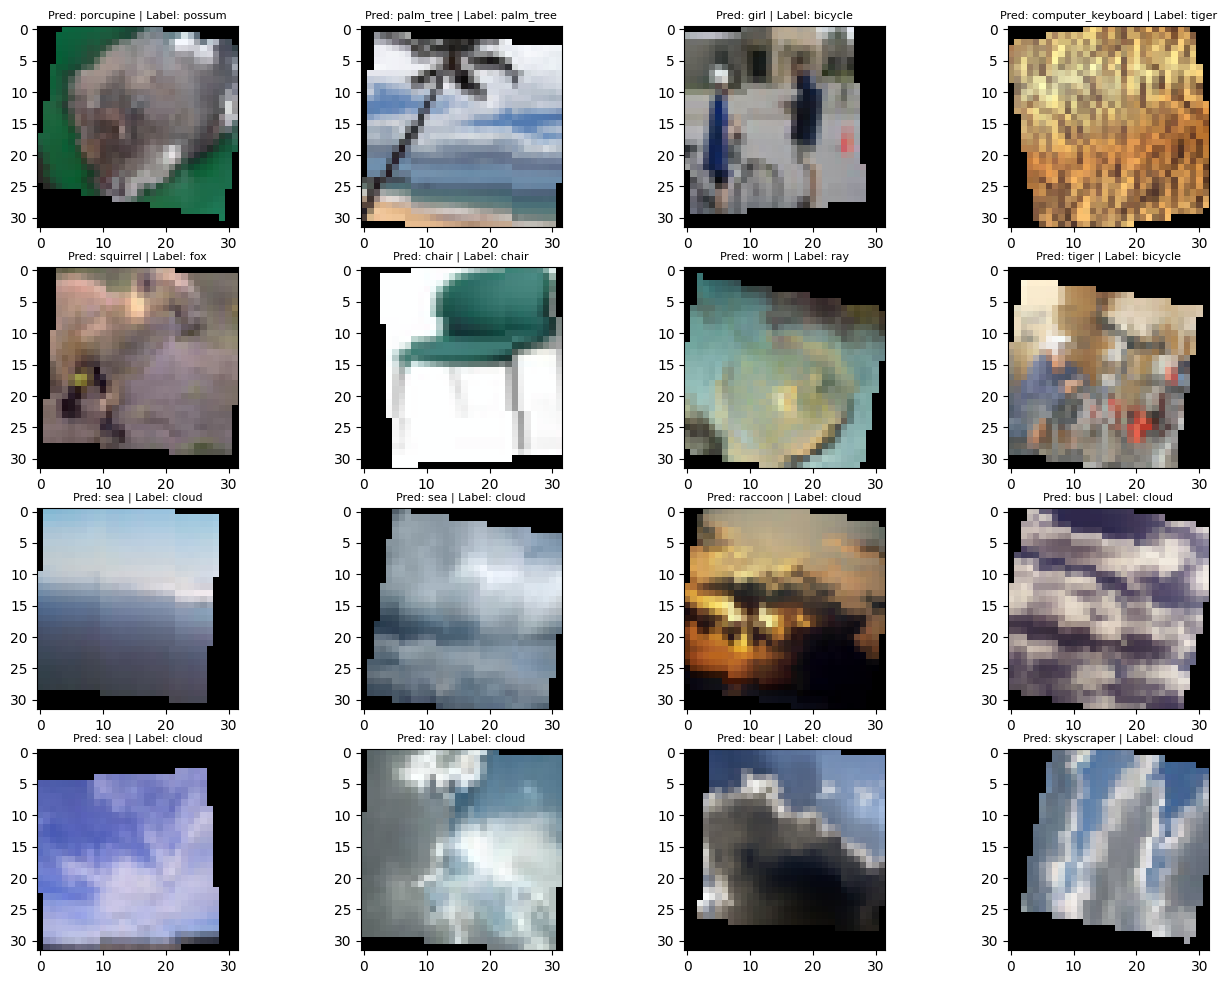

In [26]:
st_model.eval()
with torch.no_grad():
    # choose one batch from val and one batch from forget
    for (val_img, val_label), (forget_img, forget_label) in zip(val_viz_loader, forget_viz_loader):
        viz_img, viz_label = torch.cat([val_img, forget_img]), torch.cat([val_label, forget_label])
        viz_img, viz_label = viz_img.to(device), viz_label.to(device)
        out = st_model(viz_img)
        pred = out.argmax(dim=-1)
        break

# assumes BATCH_SIZE=8
fig, axes = plt.subplots(4, 4, figsize=(16,12))
for i, ax in enumerate(axes.ravel()):
    ax.set_title(f"Pred: {fine_labels[pred[i]]} | Label: {fine_labels[viz_label[i]]}", fontsize=8)
    ax.imshow(invTrans(viz_img[i]).cpu().permute(1,2,0))
plt.show()

#### 600 steps at 7.5e-4, 6.3% forget, 31% val
Forget class accuracy has significantly decreased, while on the validation data it remains somewhat competitive.
Note that there is still pretty undesirable degradation of performance. Unfortunately this type of unlearning appears to be quite unstable and sensitive to hyperparameters, in particular the learning rate and number of unlearning steps.

In [21]:
# did not test ZRF metric